# Random Forest Classification of Depression and Gender by Vocal Characteristics
In this project, we will train a Random Forest Classifier to determine whether a participant has depression based on speech data from a clinical interview. The dataset contains 107 participants, 63 of which are male and 44 of which are female. Of these participants, 30 have depression (17 female, 14 male). By varying the weights and features included in the model training, we will demonstrate how differing analysis techniques can have significant impact on the model's classification performance. 

In [210]:
# **** MATH OPERATIONS ****
import numpy as np
import os
# **** DATA MANIPULATION ****
import pandas as pd
import os


from sklearn.preprocessing import StandardScaler
# **** ML ****
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr

from scipy import stats
import numpy as np

import matplotlib.pyplot as plt

In [5]:
def load_features(path, labels_df):
    dataframes = []
    print(os.listdir(path))
    for file in os.listdir(path):
        if not file.endswith('.csv'):
            continue
        file_parts = file.split('.')
        if len(file_parts) < 2:
            continue  # Skip files without an extension
        df = pd.read_csv(os.path.join(path, file), header=None)
        participant_id = int(file_parts[0].split("_")[1]) # Get ID from file name
        df["Participant_ID"] = participant_id
        dataframes.append(df)
        
    # Combine into a single dataframe
    data_df = pd.concat(dataframes)
    return data_df.merge(labels_df, on="Participant_ID")

In [10]:
#load df
train_df = load_features("features_train", labels_df)
test_df = load_features( "features_test", labels_df)

['.DS_Store', 'spk_303.csv', 'spk_304.csv', 'spk_310.csv', 'spk_313.csv', 'spk_316.csv', 'spk_317.csv', 'spk_318.csv', 'spk_319.csv', 'spk_322.csv', 'spk_324.csv', 'spk_326.csv', 'spk_327.csv', 'spk_328.csv', 'spk_330.csv', 'spk_333.csv', 'spk_338.csv', 'spk_339.csv', 'spk_340.csv', 'spk_341.csv', 'spk_343.csv', 'spk_344.csv', 'spk_345.csv', 'spk_347.csv', 'spk_350.csv', 'spk_351.csv', 'spk_352.csv', 'spk_353.csv', 'spk_356.csv', 'spk_357.csv', 'spk_358.csv', 'spk_360.csv', 'spk_364.csv', 'spk_366.csv', 'spk_369.csv', 'spk_370.csv', 'spk_371.csv', 'spk_372.csv', 'spk_374.csv', 'spk_375.csv', 'spk_376.csv', 'spk_379.csv', 'spk_380.csv', 'spk_383.csv', 'spk_385.csv', 'spk_386.csv', 'spk_391.csv', 'spk_392.csv', 'spk_397.csv', 'spk_400.csv', 'spk_401.csv', 'spk_402.csv', 'spk_409.csv', 'spk_412.csv', 'spk_414.csv', 'spk_416.csv', 'spk_419.csv', 'spk_423.csv', 'spk_425.csv', 'spk_426.csv', 'spk_427.csv', 'spk_428.csv', 'spk_429.csv', 'spk_430.csv', 'spk_433.csv', 'spk_441.csv', 'spk_443.cs

In [13]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,Participant_ID,Depression,Gender
0,37.110800,0.016898,36.521458,37.090477,37.525204,1.003746,24.374560,11.693271,-0.207191,9.438403,...,6.140351,4.629630,0.142,0.117541,0.070000,0.027386,-39.496513,303,0,0
1,33.466145,0.081636,30.579086,32.893642,35.499447,4.920361,12.148806,0.000000,16.623375,0.000000,...,2.142857,2.222222,0.210,0.072572,0.162500,0.084963,-40.960510,303,0,0
2,31.222300,0.035549,30.420216,30.726269,31.939356,1.519140,6.691987,0.000000,23.152794,0.000000,...,2.941176,1.587302,0.230,0.000000,0.185000,0.065000,-42.518540,303,0,0
3,34.281920,0.031365,32.879463,34.713913,35.204903,2.325439,3.409068,0.000000,10.839425,0.000000,...,3.947368,2.816901,0.180,0.000000,0.100000,0.024495,-44.036240,303,0,0
4,34.795260,0.018941,34.109280,34.899593,35.433464,1.324184,16.008287,14.265874,10.287021,6.374829,...,4.000000,2.040816,0.272,0.109435,0.163333,0.170945,-42.155136,303,0,0


In [ ]:
def pre_process(train_df, test_df):
    train_df.fillna(train_df.mean(), inplace=True)
    test_df.fillna(test_df.mean(), inplace=True)

    # Exclude the last 3 columns from normalization
    columns_to_normalize = train_df.columns[:-3]

    # Normalize the selected columns using Min-Max scaling
    scaler = StandardScaler()
    train_df_normalized = train_df.copy()
    train_df_normalized[columns_to_normalize] = scaler.fit_transform(train_df[columns_to_normalize])

    # Remove outliers based on everything except the last 3 columns
    all_columns_except_last_3 = train_df.columns[:-3]
    z_scores = np.abs(stats.zscore(train_df_normalized[all_columns_except_last_3]))
    threshold = 1.5
    outlier_indices = np.where((z_scores < threshold).all(axis=1))[0]

    # Remove corresponding rows (including last 3 columns) when removing outliers
    train_df_no_outliers = train_df_normalized.drop(outlier_indices)
    test_df_normalized = test_df.copy()
    test_df_normalized[columns_to_normalize] = scaler.fit_transform(test_df[columns_to_normalize])
    return train_df_no_outliers, test_df_normalized


In [24]:
train_df_norm, test_df_norm = pre_process(train_df, test_df)

In [25]:
train_df_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,Participant_ID,Depression,Gender
0,1.457683,-1.063643,1.614355,1.443572,1.228701,-0.735037,-0.479015,-0.521202,-0.376417,-0.207485,...,1.313852,1.823350,-0.583653,0.053416,-0.363200,-0.611352,0.402052,303,0,0
2,0.702453,-0.733178,0.809862,0.637414,0.559522,-0.544366,-0.625127,-0.626473,-0.032431,-0.359591,...,-0.624234,-0.753893,-0.069887,-1.131107,-0.020244,-0.306625,-0.018123,303,0,0
5,0.850352,-0.276358,0.839325,0.730633,0.949116,0.576074,-0.649828,-0.626473,-0.082031,-0.359591,...,-0.340767,-0.057268,-0.245035,-0.022583,-0.194207,-0.402833,-0.496077,303,0,0
6,1.091946,0.652887,0.927184,1.050890,1.194443,1.087165,1.481576,2.037663,0.580316,1.623568,...,-0.141625,-0.073900,0.081376,0.930061,-0.148344,0.368244,0.955897,303,0,0
7,0.900274,-0.537293,0.984040,0.809167,0.820699,-0.226516,-0.669693,-0.626473,-0.274135,-0.359591,...,0.623019,-0.612351,0.776658,1.337879,-0.050066,-0.225610,0.724158,303,0,0


In [26]:
test_df_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,Participant_ID,Depression,Gender
0,0.819831,2.444758,-0.154389,1.266562,1.146602,4.077963,-1.273496,-0.631195,0.109137,-0.342004,...,-1.585695,-0.480799,-0.599043,-0.509762,0.052812,0.326239,1.509769,305,0,1
1,0.387973,0.057297,0.372832,0.314380,0.459008,0.388600,-0.241173,-0.513051,-0.351847,-0.267010,...,-0.346634,0.762832,-0.460486,0.210818,-0.177300,0.063272,1.884182,305,0,1
2,0.421021,1.380816,0.145457,0.017717,0.821138,2.187715,-0.132189,-0.631195,-0.646832,-0.342004,...,-1.391132,0.217312,-0.986999,-0.985629,-0.079581,-0.018725,1.822171,305,0,1
3,-0.197346,0.106698,-0.242759,-0.209687,-0.148577,0.223588,0.233065,1.234443,-0.155299,-0.202777,...,-0.661419,-0.529714,-0.482174,0.252441,0.276619,2.257103,1.642903,305,0,1
4,-0.268974,1.109325,-0.762356,-0.081767,-0.142671,1.729355,-0.345124,-0.438056,-0.321966,-0.173071,...,-1.077782,0.107729,-0.779165,-0.377861,-0.027885,1.245583,0.897404,305,0,1


In [31]:
X_train = train_df_norm.drop(["Participant_ID", "Depression", "Gender"], axis=1)
y_train_depression = train_df_norm["Depression"]
y_train_gender= train_df_norm["Gender"]

# Apply the same transformation to the test data
X_test = test_df_norm.drop(["Participant_ID", "Depression", "Gender"], axis=1)
y_test_depression = test_df_norm["Depression"]
y_test_gender = test_df_norm["Gender"]

In [89]:
def display_accuracy(gender, metric):
    print(f"Metrics for {gender}:")
    print(f"Accuracy: {metric['accuracy']:.2f}")
    print(f"Balanced Accuracy: {metric['balanced_accuracy']:.2f}")
    print(f"True Positive Rate (TPR): {metric['tpr']:.2f}")
    print(f"True Negative Rate (TNR): {metric['tnr']:.2f}")
    print(f"False Positive Rate (FPR): {metric['fpr']:.2f}")
    print(f"False Negative Rate (FNR): {metric['fnr']:.2f}")
    print("\n")

In [59]:
def manual_confusion_matrix(y_true, y_pred):
    # Initialize counts for true negatives (TN), false positives (FP), 
    # false negatives (FN), and true positives (TP)
    tn = fp = fn = tp = 0
    
    # Iterate over each pair of true and predicted labels
    for true_label, pred_label in zip(y_true, y_pred):
        if true_label == 0 and pred_label == 0:
            tn += 1
        elif true_label == 0 and pred_label == 1:
            fp += 1
        elif true_label == 1 and pred_label == 0:
            fn += 1
        elif true_label == 1 and pred_label == 1:
            tp += 1
    
    return tn, fp, fn, tp

In [66]:
def calculate_accuracy(y_true, y_pred):
    # Calculate Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate Balanced Accuracy
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    
    # Extract TP, FP, TN, FN
    tn, fp, fn, tp = manual_confusion_matrix(y_true, y_pred)
    if(tp+fn == 0):
        tpr = None
        fnr = None
    else:
        tpr = tp / (tp + fn) # True Positive Rate
        fnr = fn / (fn + tp) # False Negative Rate
    if(tn+fp == 0):
        tnr = None
        fpr = None
    else:
        tnr = tn / (tn + fp) # True Negative Rate
        fpr = fp / (fp + tn) # False Positive Rate
    
    
    # Store metrics
    metrics = {
        "accuracy": accuracy,
        "balanced_accuracy": balanced_accuracy,
        "tpr": tpr,
        "tnr": tnr,
        "fpr": fpr,
        "fnr": fnr
    }
    return metrics

In [68]:
def train_random_forest(X, y):
    l = len(X)
    X_train = X[:int(0.7*l)]
    y_train = y[:int(0.7*l)]
    X_val = X[int(-0.3*l):]
    y_val = y[int(-0.3*l):]
    n_estimators = [10, 20, 50, 100]
    max_depth = [None, 10, 20]
    best_acc = 0
    best_model = None
    best_param = None

    for n in n_estimators:
        for d in max_depth:
            print('Now training:', n, d)
            clf = RandomForestClassifier(random_state = 42, class_weight = 'balanced', n_estimators = n, max_depth = d)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_val)
            print(y_pred)
            print(np.array(y_val))
            metric = calculate_accuracy(np.array(y_val), y_pred)
            if(metric['accuracy'] > best_acc):
                best_acc = metric['accuracy']
                best_model = clf
                best_param = n,d
            print('best accuracy', best_acc, best_param)
    return best_acc, best_model, best_param
            


In [71]:
best_acc_gender, best_model_gender, best_param_gender = train_random_forest(X_train, y_train_gender)

Now training: 10 None
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
best accuracy 0.858843537414966 (10, None)
Now training: 10 10
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
best accuracy 0.858843537414966 (10, None)
Now training: 10 20
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
best accuracy 0.8602607709750567 (10, 20)
Now training: 20 None
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
best accuracy 0.8639455782312925 (20, None)
Now training: 20 10
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
best accuracy 0.8642290249433107 (20, 10)
Now training: 20 20
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
best accuracy 0.8642290249433107 (20, 10)
Now training: 50 None
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
best accuracy 0.8642290249433107 (20, 10)
Now training: 50 10
[0 0 1 ... 0 1 0]
[0 0 0 ... 0 0 0]
best accuracy 0.8642290249433107 (20, 10)
Now training: 50 20
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
best accuracy 0.8642290249433107 (20, 10)
Now training: 100 None
[0 0 1 ... 0 1 0]
[0 0 0 ... 0 0 0]
best accuracy 0.8642290249433107 (20, 10)
Now tra

In [73]:
print('Accuracy:',best_acc_gender,' and best parameters: ',best_param_gender)

Accuracy: 0.8642290249433107  and best parameters:  (20, 10)


In [74]:
best_acc_depression, best_model_depression, best_param_depression = train_random_forest(X_train, y_train_depression)

Now training: 10 None
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
best accuracy 0.7392290249433107 (10, None)
Now training: 10 10
[1 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
best accuracy 0.7392290249433107 (10, None)
Now training: 10 20
[0 0 0 ... 1 0 1]
[0 0 0 ... 0 0 0]
best accuracy 0.7392290249433107 (10, None)
Now training: 20 None
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
best accuracy 0.7579365079365079 (20, None)
Now training: 20 10
[0 0 0 ... 1 0 1]
[0 0 0 ... 0 0 0]
best accuracy 0.7579365079365079 (20, None)
Now training: 20 20
[0 0 0 ... 1 0 1]
[0 0 0 ... 0 0 0]
best accuracy 0.7579365079365079 (20, None)
Now training: 50 None
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
best accuracy 0.7695578231292517 (50, None)
Now training: 50 10
[0 0 0 ... 1 0 1]
[0 0 0 ... 0 0 0]
best accuracy 0.7695578231292517 (50, None)
Now training: 50 20
[0 0 0 ... 1 0 1]
[0 0 0 ... 0 0 0]
best accuracy 0.7695578231292517 (50, None)
Now training: 100 None
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
best accuracy 0.7752267573696145 (1

In [75]:
print('Accuracy:',best_acc_depression,' and best parameters: ',best_param_depression)

Accuracy: 0.7752267573696145  and best parameters:  (100, None)


In [94]:
def analyze_results(test_df, threshold,class_type,display_results=True):

    # Filter data by gender
    male_participants = test_df[test_df["Gender"] == 1]["Participant_ID"].unique()
    female_participants = test_df[test_df["Gender"] == 0]["Participant_ID"].unique()

    if(class_type == 'Gender'):
        participant_predictions_gender = test_df.groupby("Participant_ID")["prediction_gender"].mean()
        participant_predictions_gender_binarized = (participant_predictions_gender >= threshold).astype(int)

        participant_labels_gender = test_df.groupby("Participant_ID")["Gender"].first()

        metrics = calculate_accuracy(participant_labels_gender, participant_predictions_gender_binarized)
        eo = (1 - abs(metrics["tpr"] - metrics["tnr"]))
        if(display_results):
            display_accuracy('Gender', metrics)
            print(f"Equality of Opportunity (EO): {eo:.2f}")
        return metrics

    if(class_type == 'Depression'):
    
        # Group by participant and average predictions 
        participant_predictions_depression = test_df.groupby("Participant_ID")["prediction_depression"].mean()
        
        participant_predictions_depression_binarized = (participant_predictions_depression >= threshold).astype(int)
    
        # Join aggregated predictions back with the depression labels
        participant_labels_depression = test_df.groupby("Participant_ID")["Depression"].first()
    
        
    
        # Calculate accuracies for all, male, and female participants
        metrics = calculate_accuracy(participant_labels_depression, participant_predictions_depression_binarized)
        male_metrics = calculate_accuracy(participant_labels_depression.loc[male_participants], participant_predictions_depression_binarized.loc[male_participants])
        female_metrics = calculate_accuracy(participant_labels_depression.loc[female_participants], participant_predictions_depression_binarized.loc[female_participants])
        eo = (1 - abs(metrics["tpr"] - metrics["tnr"]))
        if display_results:
            display_accuracy('Depression', metrics)
            display_accuracy('Male', male_metrics)
            display_accuracy('Female', female_metrics)
            print(f"Equality of Opportunity (EO): {eo:.2f}")
        return metrics, male_metrics, female_metrics
        

    print('Please recheck the parameters')

    return 

In [78]:
test_df['prediction_gender'] = best_model_gender.predict(X_test)

In [77]:
test_df['prediction_depression']= best_model_depression.predict(X_test)

# Problem (a.i) Depression Classification

In [90]:
depreesion_metric, male_metric, female_metric = analyze_results(test_df, 0.2, 'Depression')

Metrics for Depression:
Accuracy: 0.75
Balanced Accuracy: 0.63
True Positive Rate (TPR): 0.33
True Negative Rate (TNR): 0.93
False Positive Rate (FPR): 0.07
False Negative Rate (FNR): 0.67


Metrics for Male:
Accuracy: 0.92
Balanced Accuracy: 0.95
True Positive Rate (TPR): 1.00
True Negative Rate (TNR): 0.91
False Positive Rate (FPR): 0.09
False Negative Rate (FNR): 0.00


Metrics for Female:
Accuracy: 0.50
Balanced Accuracy: 0.60
True Positive Rate (TPR): 0.20
True Negative Rate (TNR): 1.00
False Positive Rate (FPR): 0.00
False Negative Rate (FNR): 0.80


Equality of Opportunity (EO): 0.40


# Problem (a.ii) Gender Classification

In [95]:
gendre_metric = analyze_results(test_df, 0.2, 'Gender')

Metrics for Gender:
Accuracy: 0.85
Balanced Accuracy: 0.81
True Positive Rate (TPR): 1.00
True Negative Rate (TNR): 0.62
False Positive Rate (FPR): 0.38
False Negative Rate (FNR): 0.00


Equality of Opportunity (EO): 0.62


## Problem (1b) Depression Feature Selection

In this section, we will repeat the same depression classification as above on only the features with the strongest correlation with depression.

In [23]:
# grab feature names
features = pd.read_csv('feature_description.csv',
                    encoding = 'ISO-8859-1', 
                    names=['feature', 'description'])['feature'].values.tolist()
col_names = {x:features[x] for x in range(88)}
train_df.rename(columns=col_names, inplace=True)
test_df.rename(columns=col_names, inplace=True)
# perform depression classification on the data
correlation_tups = []
for col in train_df.columns:
    if col in ['Participant_ID', 'Depression']:
        continue
    correlation_tups.append((col, train_df[col].corr(train_df['Depression'])))
correlation_tups = sorted(correlation_tups, key=lambda x: abs(x[1]), reverse=True)
top_twenty_feats = {correlation_tups[x][0]:round(correlation_tups[x][1], 3)  for x in range(20)}
print('Top twenty features correlated with depression: \n')
for key, val in top_twenty_feats.items():
    print(f'{key}: {val}')

Top twenty features correlated with depression: 

loudness_sma3_pctlrange0-2: 0.178
loudness_sma3_percentile80.0: 0.174
loudness_sma3_amean: 0.168
loudness_sma3_percentile50.0: 0.14
spectralFluxV_sma3nz_amean: 0.135
spectralFlux_sma3_amean: 0.119
HNRdBACF_sma3nz_amean: 0.115
loudness_sma3_meanRisingSlope: 0.115
F0semitoneFrom27.5Hz_sma3nz_percentile50.0: 0.111
F0semitoneFrom27.5Hz_sma3nz_percentile20.0: 0.109
F0semitoneFrom27.5Hz_sma3nz_amean: 0.107
F0semitoneFrom27.5Hz_sma3nz_percentile80.0: 0.104
loudness_sma3_meanFallingSlope: 0.103
Gender: -0.099
loudness_sma3_stddevRisingSlope: 0.097
equivalentSoundLevel_dBp: 0.091
loudness_sma3_stddevFallingSlope: 0.091
spectralFluxV_sma3nz_stddevNorm: 0.091
mfcc3_sma3_amean: -0.085
loudness_sma3_percentile20.0: 0.082


The participants with depression more frequently spoke loudly (loudness_sma3) and with more fluctuations (spectralFlux). There is also slight correlation between the vocal range (semitone) and the speaker's depression. Since the majority of participants with depression were female, there is a correlation between gender and depression, as well.

We will now train a Random Forest Classifier to predict depression using only the features most strongly correlated with depression. 

In [51]:
# run model on filtered features
class_acc, bca, male_class_acc, male_bca, female_class_acc, female_bca, eo, num_trees, depth = [],[],[],[],[],[],[], [], []
for n in range(10, 51, 5):
    # select top performing features
    features = [correlation_tups[x][0] for x in range(n)] + ['Depression']
    filtered_df = train_df.loc[:, features]
    # build random forest on these features
    best_rand_forest, n_trees, n_depth = train_random_forest(filtered_df, 'Depression', depth_list = [1], tree_list = [5])
    filtered_test = test_df.loc[:, features]
    predictions = best_rand_forest.predict(filtered_test.drop(columns=['Depression']).to_numpy())
    # store accuracies
    test_df_pred = test_df.copy()
    test_df_pred['predictions'] = predictions
    all_res, male_res, female_res, eo_res = analyze_results(test_df_pred, display_results=False)
    class_acc.append(all_res['accuracy'])
    bca.append(all_res['balanced_accuracy'])
    male_class_acc.append(male_res['accuracy'])
    male_bca.append(male_res['balanced_accuracy'])
    female_class_acc.append(female_res['accuracy'])
    female_bca.append(female_res['balanced_accuracy'])
    eo.append(eo_res)
    num_trees.append(n_trees)
    depth.append(n_depth)
num_trees = [x/max(num_trees) for x in num_trees]
depth = [x/max(depth) for x in depth]

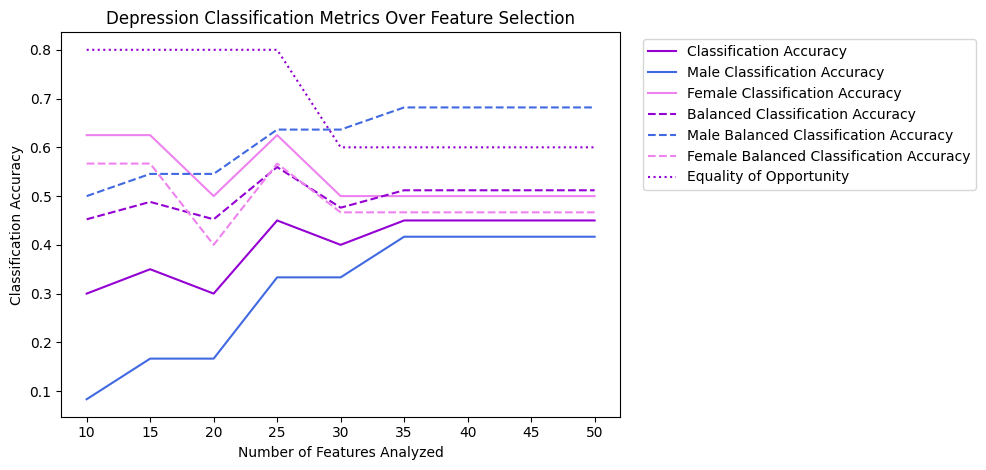

In [52]:
from matplotlib import pyplot as plt
# plot results
fig, ax = plt.subplots(1, 1)
num_feats = range(10, 51, 5)
ax.plot(num_feats, class_acc, label = "Classification Accuracy", color='darkviolet') 
ax.plot(num_feats, male_class_acc, label = "Male Classification Accuracy", color='royalblue') 
ax.plot(num_feats, female_class_acc, label = "Female Classification Accuracy", color='violet') 
ax.plot(num_feats, bca, label = "Balanced Classification Accuracy", color='darkviolet', linestyle='dashed') 
ax.plot(num_feats, male_bca, label = "Male Balanced Classification Accuracy", color='royalblue', linestyle='dashed') 
ax.plot(num_feats, female_bca, label = "Female Balanced Classification Accuracy", color='violet', linestyle='dashed') 
ax.plot(num_feats, eo, label = "Equality of Opportunity", color='darkviolet', linestyle='dotted')
ax.set_title('Depression Classification Metrics Over Feature Selection')
ax.set_xlabel('Number of Features Analyzed')
ax.set_ylabel('Classification Accuracy')
fig.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 0.5, 0.5, 0.5)) 
plt.show()

The above plot shows the depression classification accuracy measures over male and female participants as the number of features included in the model increase. With minimal (10) features included in the model training, the Random Forest Classifier performs much better on female participants than on male participants. As more features (with decreasing correlation) increase, the classification accuracy on male participants increases, while the classification accuracy on female participants decreases. As the number of features increase, the equality of opportunity nears 60% and the overall classification and balanced classification accuracy nears 50%.

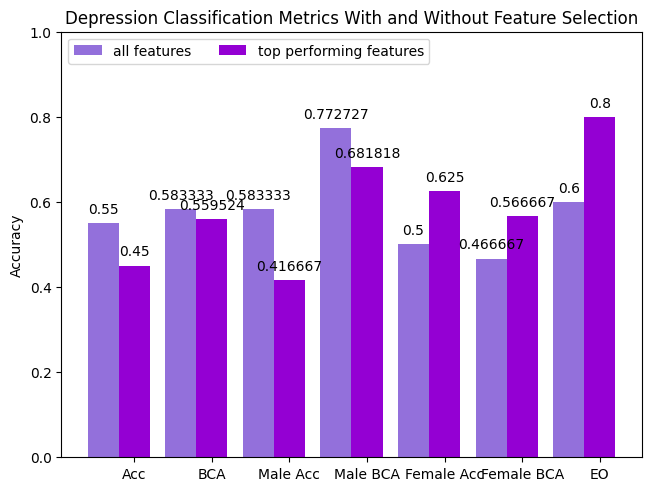

In [56]:
import math
# plot results for depression with and without feature selection
best_ind = bca.index(max(bca))
best_male_ind = male_bca.index(max(male_bca))
best_female_ind = female_bca.index(max(female_bca))
measures = ['Acc', 'BCA', 'Male Acc', 'Male BCA', 'Female Acc', 'Female BCA', 'EO']
vals = {
    'all features': [all_metrics_depression['accuracy'], all_metrics_depression['balanced_accuracy'], 
                     male_metrics['accuracy'], male_metrics['balanced_accuracy'], 
                     female_metrics['accuracy'], female_metrics['balanced_accuracy'], .6],
    'top performing features': [class_acc[best_ind], bca[best_ind], 
                          male_class_acc[best_male_ind], male_bca[best_male_ind],
                          female_class_acc[best_female_ind], female_bca[best_female_ind], eo[best_ind]]
}
x = np.arange(len(measures))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in vals.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color='mediumpurple' if attribute=='all features' else 'darkviolet')
    ax.bar_label(rects, padding=5)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Depression Classification Metrics With and Without Feature Selection')
ax.set_xticks(x + width, measures)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1)


plt.show()


The balanced classification accuracy sees little change from the best performing feature-selection model to the original model. The overall classification accuracy is significantly higher with the original model than with the feature selection model, but these values would likely converge as the number of features included in the analysis increases. 
The original model performs better on classifying the male participants, with a 9% difference in the balanced classificaiton accuracy. However, the feature-selection model performs better on classifying female participants, with a 10% increase in the balanced classification accuracy. Furthermore, the Equality of Opportunity score increases 20% with the feature-selection model. 

# Problem (c) Feature selection

In [147]:
features = pd.read_csv('feature_description.csv',
                    encoding = 'ISO-8859-1')

In [149]:
features.head()

,F0semitoneFrom27.5Hz_sma3nz_amean,"mean logarithmic F0 on a semitone frequency scale, starting at 27.5 Hz (semitone 0)"
0,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,standard deviation of logarithmic F0 on a semi...
1,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,20th percentile of logarithmic F0 on a semiton...
2,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,50th percentile of logarithmic F0 on a semiton...
3,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,80th percentile of logarithmic F0 on a semiton...
4,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,range of 20th to 80th percentile of logarithmi...


In [151]:
column_name_features = features.columns

In [110]:
i = 20  # Number of features
X_train_mod = X_train.values
correlations = [abs(pearsonr(X_train_mod[:, j], y_train_gender)[0]) for j in range(X_train.shape[1])]
top_feature_indices = sorted(range(len(correlations)), key=lambda j: correlations[j], reverse=True)[:i]
X_train_selected = X_train_mod[:, top_feature_indices]


In [152]:
features.rename(columns={column_name_features[0]: 'Features', column_name_features[1]: 'Description'}, inplace=True)


In [153]:
features.head()

,Features,Description
0,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,standard deviation of logarithmic F0 on a semi...
1,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,20th percentile of logarithmic F0 on a semiton...
2,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,50th percentile of logarithmic F0 on a semiton...
3,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,80th percentile of logarithmic F0 on a semiton...
4,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,range of 20th to 80th percentile of logarithmi...


In [156]:
feature_names = features['Features'].tolist()
descriptions = features['Description'].tolist()

In [136]:
def find_best_features(X, y, best_prams):
    l = len(X)
    X_train = X[:int(0.7*l)]
    X_train = X_train.values
    y_train = y[:int(0.7*l)]
    X_val = X[int(-0.3*l):]
    X_val = X_val.values
    y_val = y[int(-0.3*l):]
    clf = RandomForestClassifier(random_state = 42, class_weight = 'balanced', n_estimators = best_prams[0], max_depth = best_prams[1])

    # Declare range
    num_features = range(5, 31, 5)
    result = []
    correlations = [abs(pearsonr(X_train[:, i], y_train)[0]) for i in range(X_train.shape[1])]

    for num in num_features:
        top_feature_indices = sorted(range(len(correlations)), key=lambda i: correlations[i], reverse=True)[:num]
        X_train_selected = X_train[:, top_feature_indices]
        X_val_selected = X_val[:, top_feature_indices]
        clf.fit(X_train_selected, y_train)
        y_pred = clf.predict(X_val_selected)
        metrics = calculate_accuracy(y_val, y_pred)
        result.append({'model':clf, 'indices':top_feature_indices,'Number of Features': num, 'Accuracy':metrics['accuracy']})
    return result, correlations
    

In [137]:
result_gender, correlations_gender = find_best_features(X_train, y_train_gender, best_param_gender)

In [244]:
best_acc_filtered_gender = 0
n_best  = None
top_feature_df_gender_list = []
for n in result_gender:
    if(n['Accuracy'] > best_acc_filtered_gender):
        best_acc_filtered_gender = n['Accuracy']
        n_best = n
    top_feature_df_gender_list.append({'Number of Features': n['Number of Features'], 'Accuracy':n['Accuracy']})
    print("Number of features: ", n['Number of Features']," gave accuracy of: ", n['Accuracy'])
top_feature_df_gender = pd.DataFrame(top_feature_df_gender_list)

Number of features:  5  gave accuracy of:  0.8486394557823129
Number of features:  10  gave accuracy of:  0.8463718820861678
Number of features:  15  gave accuracy of:  0.8537414965986394
Number of features:  20  gave accuracy of:  0.8574263038548753
Number of features:  25  gave accuracy of:  0.846655328798186
Number of features:  30  gave accuracy of:  0.8619614512471655


In [245]:
top_feature_df_gender.head()

,Number of Features,Accuracy
0,5,0.848639
1,10,0.846372
2,15,0.853741
3,20,0.857426
4,25,0.846655


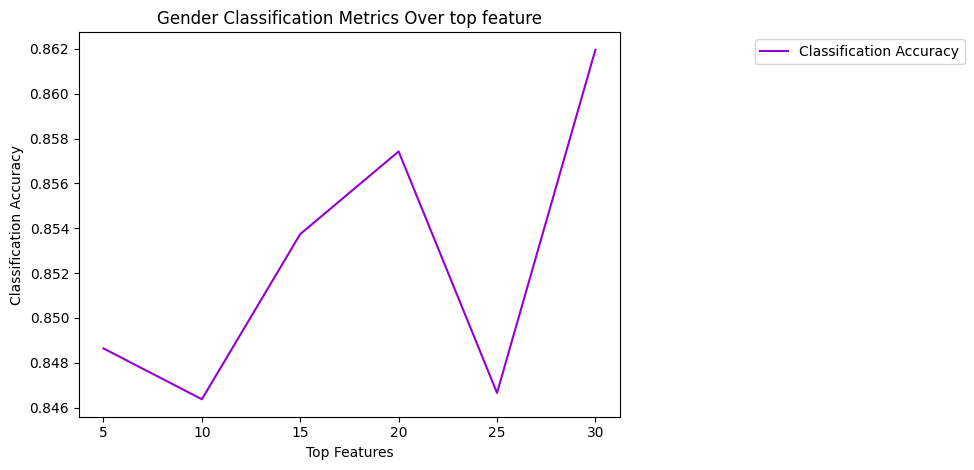

In [247]:
# plot results
fig, ax = plt.subplots(1, 1)
num_top_features = range(5, 31, 5)
ax.plot(num_top_features, top_feature_df_gender['Accuracy'], label = "Classification Accuracy", color='darkviolet') 
ax.set_title('Gender Classification Metrics Over top feature')
ax.set_xlabel('Top Features')
ax.set_ylabel('Classification Accuracy')
fig.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 0.5, 0.5, 0.5)) 
plt.show()

## Finding the most informative features for gender

In [158]:
top_feature_names = [feature_names[index] for index in result_gender[3]['indices']]
top_description = [descriptions[index] for index in result_gender[3]['indices']]

# Create a DataFrame with feature names and their corresponding correlations
correlation_df = pd.DataFrame({
    'Feature': top_feature_names,
    'Feature Description': top_description,
    'Correlation': [correlations[index] for index in result_gender[3]['indices']]
})

correlation_df

,Feature,Feature Description,Correlation
0,HNRdBACF_sma3nz_stddevNorm,standard deviation of Harmonics-to-Noise Ratio...,0.616603
1,slopeV0-500_sma3nz_stddevNorm,standard deviation of spectral slope from 0Ð50...,0.560016
2,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,80th percentile of logarithmic F0 on a semiton...,0.571997
3,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,50th percentile of logarithmic F0 on a semiton...,0.569876
4,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,standard deviation of logarithmic F0 on a semi...,0.561701
5,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,range of 20th to 80th percentile of logarithmi...,0.547992
6,mfcc4V_sma3nz_stddevNorm,standard deviation of the fourth Mel-Frequency...,0.409428
7,mfcc4_sma3_stddevNorm,standard deviation of the fourth Mel-Frequency...,0.388414
8,shimmerLocaldB_sma3nz_amean,mean shimmer,0.324747
9,HNRdBACF_sma3nz_amean,mean Harmonics-to-Noise Ratio (HNR),0.247190


In [167]:
X_test_temp = X_test.values
test_df_temp = test_df.copy()
test_df_temp['prediction_gender']= n_best['model'].predict(X_test_temp[:,n['indices']])

In [169]:
filtered_metric_gender = analyze_results(test_df_temp, 0.2, 'Gender')

Metrics for Gender:
Accuracy: 0.85
Balanced Accuracy: 0.81
True Positive Rate (TPR): 1.00
True Negative Rate (TNR): 0.62
False Positive Rate (FPR): 0.38
False Negative Rate (FNR): 0.00


Equality of Opportunity (EO): 0.62


In [178]:
filtered_metric_gender

{'accuracy': 0.85,
 'balanced_accuracy': 0.8125,
 'tpr': 1.0,
 'tnr': 0.625,
 'fpr': 0.375,
 'fnr': 0.0}

# d) Mitigating bias via removing gender-dependent features

In [237]:
def get_filtered_results(X_train, y_train, X_test, y_test, result, best_param, df):
    X_train_temp = X_train.values
    X_test_temp = X_test.values
    clf_filtered = RandomForestClassifier(random_state = 42, class_weight = 'balanced', n_estimators = best_param_depression[0], max_depth = best_param_depression[1])
    results_df = pd.DataFrame(columns=['accuracy', 'ba_accuracy', 'male_accuracy', 'ba_male_accuracy', 'female_accuracy', 'ba_female_accuracy'])
    results_list = []
    for n in result:
        print("Training with number of features removed: ", n['Number of Features'])
        X_train_filtered = X_train_temp[:, ~np.isin(np.arange(X_train_temp.shape[1]), n['indices'])]
        print(X_train_filtered.shape)
        X_test_filtered = X_test_temp[:, ~np.isin(np.arange(X_test_temp.shape[1]), n['indices'])]
        clf_filtered.fit(X_train_filtered, y_train)
        df['prediction_depression'] = clf_filtered.predict(X_test_filtered)
        # depreesion_metric  = calculate_accuracy(y_test, y_pred)
        depreesion_metric, male_metric, female_metric = analyze_results(df, 0.2, 'Depression', False)
        eo = (1 - abs(depreesion_metric["tpr"] - depreesion_metric["tnr"]))
        results_list.append({
            'accuracy': metric_removed_features['accuracy'],
            'male_accuracy': male_metric['accuracy'],
            'female_accuracy':female_metric['accuracy'],
            'ba_accuracy': metric_removed_features['balanced_accuracy'],
            'ba_male_accuracy': male_metric['balanced_accuracy'],
            'ba_female_accuracy':female_metric['balanced_accuracy'],
            'eo': eo
        })
    results_df = pd.DataFrame(results_list)
    return results_df

In [239]:
result_df_filetered = get_filtered_results(X_train, y_train_depression, X_test, y_test_depression, result_gender, best_param_depression, test_df_temp)

Training with number of features removed:  5
(11762, 83)
Training with number of features removed:  10
(11762, 78)
Training with number of features removed:  15
(11762, 73)
Training with number of features removed:  20
(11762, 68)
Training with number of features removed:  25
(11762, 63)
Training with number of features removed:  30
(11762, 58)


In [240]:
result_df_filetered.head()

,accuracy,male_accuracy,female_accuracy,ba_accuracy,ba_male_accuracy,ba_female_accuracy,eo
0,0.65,0.833333,0.375,0.464286,0.454545,0.5,0.071429
1,0.65,0.916667,0.375,0.464286,0.500000,0.5,0.000000
2,0.65,0.833333,0.375,0.464286,0.454545,0.5,0.071429
3,0.65,0.916667,0.375,0.464286,0.500000,0.5,0.000000
4,0.65,0.916667,0.375,0.464286,0.500000,0.5,0.000000


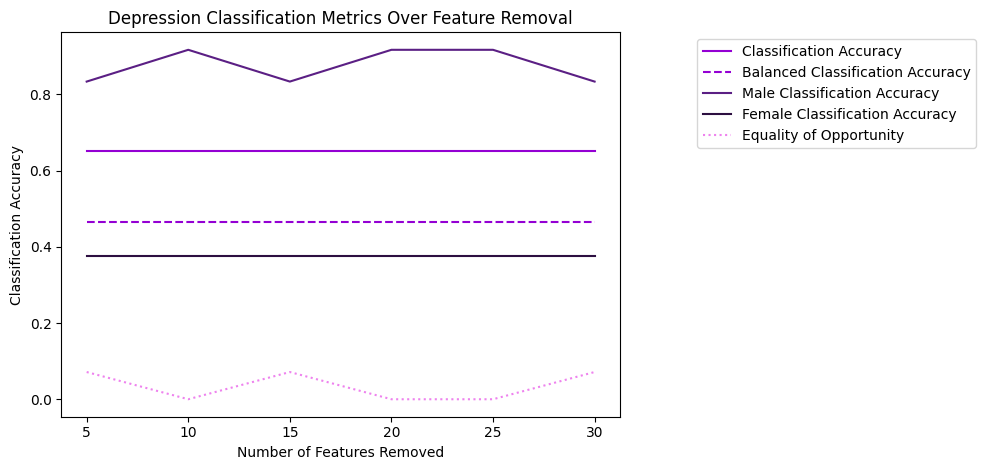

In [241]:
# plot results
fig, ax = plt.subplots(1, 1)
num_feats_removed = range(5, 31, 5)
ax.plot(num_feats_removed, result_df_filetered['accuracy'], label = "Classification Accuracy", color='darkviolet') 
ax.plot(num_feats_removed, result_df_filetered['ba_accuracy'], label = "Balanced Classification Accuracy", color='darkviolet', linestyle='dashed') 
ax.plot(num_feats_removed, result_df_filetered['male_accuracy'], label = "Male Classification Accuracy", color='#5B1F84') 
ax.plot(num_feats_removed, result_df_filetered['female_accuracy'], label = "Female Classification Accuracy", color='#2D0F41') 
ax.plot(num_feats_removed, result_df_filetered['eo'], label = "Equality of Opportunity", color='violet', linestyle='dotted')
ax.set_title('Depression Classification Metrics Over Feature Removal')
ax.set_xlabel('Number of Features Removed')
ax.set_ylabel('Classification Accuracy')
fig.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 0.5, 0.5, 0.5)) 
plt.show()